In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Load dataset
df = pd.read_csv("C:\Cleaned_User_Matching_Dataset.csv")
df.head()

,user_id,user_type,startup_stage,startup_industry,project_need,tech_requirement,project_deadline,expertise_area,industry_preference,preferred_project_type,core_skill,availability
0,F001,Founder,Ideation,SaaS,Digital Marketing,AWS,1 Month,NaN,NaN,NaN,NaN,NaN
1,F002,Founder,Ideation,FinTech,Pitch Deck Design,React,2 Months,NaN,NaN,NaN,NaN,NaN
2,F003,Founder,Scaling,SaaS,Pitch Deck Design,GST Filing,1 Month,NaN,NaN,NaN,NaN,NaN
3,F004,Founder,Early Growth,SaaS,Fundraising Support,React,2 Weeks,NaN,NaN,NaN,NaN,NaN
4,F005,Founder,Early Growth,HealthTech,Fundraising Support,Python,2 Months,NaN,NaN,NaN,NaN,NaN


In [2]:
founders = df[df['user_type'] == 'Founder'].reset_index(drop=True)
providers = df[df['user_type'].isin(['Service Provider', 'Mentor'])].reset_index(drop=True)


In [3]:
timeline_map = {'2 Weeks': 1, '1 Month': 2, '2 Months': 3, '3 Months+': 4}
founders['deadline_numeric'] = founders['project_deadline'].map(timeline_map).fillna(999)
providers['availability_numeric'] = providers['availability'].map(timeline_map).fillna(999)


In [4]:
def compute_match_score(founder, provider):
    score = 0
    if pd.notna(founder['startup_industry']) and pd.notna(provider['industry_preference']):
        if founder['startup_industry'].strip().lower() == provider['industry_preference'].strip().lower():
            score += 25
        elif founder['startup_industry'].strip().lower() in provider['industry_preference'].strip().lower():
            score += 10
    if pd.notna(founder['tech_requirement']) and pd.notna(provider['core_skill']):
        if founder['tech_requirement'].strip().lower() == provider['core_skill'].strip().lower():
            score += 25
    if pd.notna(founder['project_need']) and pd.notna(provider['preferred_project_type']):
        vec = TfidfVectorizer().fit_transform([founder['project_need'], provider['preferred_project_type']])
        sim = cosine_similarity(vec[0:1], vec[1:2])[0][0]
        score += sim * 20
    if founder['deadline_numeric'] < 999 and provider['availability_numeric'] < 999:
        diff = abs(founder['deadline_numeric'] - provider['availability_numeric'])
        score += 20 if diff == 0 else 10 if diff == 1 else 0
    if pd.notna(founder['startup_stage']) and pd.notna(provider['expertise_area']):
        if founder['startup_stage'].strip().lower() in ['ideation', 'validation'] and 'pitch' in provider['expertise_area'].strip().lower():
            score += 10
    return round(score, 2)


In [5]:
match_matrix = pd.DataFrame(index=founders['user_id'], columns=providers['user_id'])
for i, f_row in founders.iterrows():
    for j, p_row in providers.iterrows():
        match_matrix.loc[f_row['user_id'], p_row['user_id']] = compute_match_score(f_row, p_row)
match_matrix = match_matrix.astype(float)
match_matrix.head()

user_id,S001,S002,S003,S004,S005,S006,S007,S008,S009,S010,...,S041,S042,S043,S044,S045,S046,S047,S048,S049,S050
user_id,,,,,,,,,,,,,,,,,,,,,
F001,20.0,20.0,20.0,20.0,10.0,20.0,10.0,70.0,50.0,20.0,...,0.0,20.0,20.0,35.0,20.0,20.0,45.0,55.0,10.0,20.0
F002,10.0,35.0,10.0,10.0,20.0,55.0,20.0,10.0,0.0,10.0,...,0.0,50.0,10.0,0.0,10.0,0.0,0.0,20.0,45.0,10.0
F003,35.0,20.0,20.0,20.0,35.0,40.0,10.0,45.0,25.0,35.0,...,0.0,30.0,20.0,35.0,20.0,0.0,25.0,35.0,10.0,45.0
F004,20.0,10.0,10.0,10.0,0.0,35.0,0.0,55.0,25.0,20.0,...,0.0,0.0,10.0,45.0,10.0,0.0,25.0,25.0,45.0,10.0
F005,0.0,10.0,35.0,35.0,20.0,35.0,20.0,30.0,0.0,0.0,...,25.0,45.0,35.0,0.0,10.0,0.0,25.0,45.0,65.0,35.0


In [6]:
def get_top_matches(matrix, top_n=3):
    top_matches = {}
    for idx in matrix.index:
        sorted_scores = matrix.loc[idx].sort_values(ascending=False)
        top_matches[idx] = sorted_scores.head(top_n)
    return top_matches

top_founder_matches = get_top_matches(match_matrix.iloc[:5])
top_provider_matches = get_top_matches(match_matrix.T.iloc[:5])


In [7]:
def format_match_summary(top_matches, reverse=False):
    summary = []
    for user, matches in top_matches.items():
        for match_id, score in matches.items():
            summary.append({
                'user_id': user,
                'match_id': match_id if not reverse else user,
                'matched_with': user if reverse else match_id,
                'match_score': score
            })
    return pd.DataFrame(summary)

founder_summary_df = format_match_summary(top_founder_matches)
founder_summary_df

,user_id,match_id,matched_with,match_score
0,F001,S008,S008,70.0
1,F001,S015,S015,70.0
2,F001,S021,S021,60.0
3,F002,S016,S016,80.0
4,F002,S040,S040,65.0
5,F002,S006,S006,55.0
6,F003,S011,S011,70.0
7,F003,S015,S015,65.0
8,F003,S050,S050,45.0
9,F004,S022,S022,60.0


In [8]:
# Provider-focused match summary
provider_match_matrix = match_matrix.T
top_providers_founders = get_top_matches(provider_match_matrix.iloc[:5])
provider_summary = []
for provider_id, matches in top_providers_founders.items():
    for founder_id, score in matches.items():
        provider_summary.append({
            'provider_id': provider_id,
            'founder_id': founder_id,
            'match_score': score
        })
pd.DataFrame(provider_summary)

,provider_id,founder_id,match_score
0,S001,F043,65.0
1,S001,F034,55.0
2,S001,F050,50.0
3,S002,F048,55.0
4,S002,F040,45.0
5,S002,F006,45.0
6,S003,F033,60.0
7,S003,F025,55.0
8,S003,F031,45.0
9,S004,F024,65.0


### 📊 Optional: Add visualizations here
Use seaborn or plotly to create a heatmap or bar charts of match scores.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


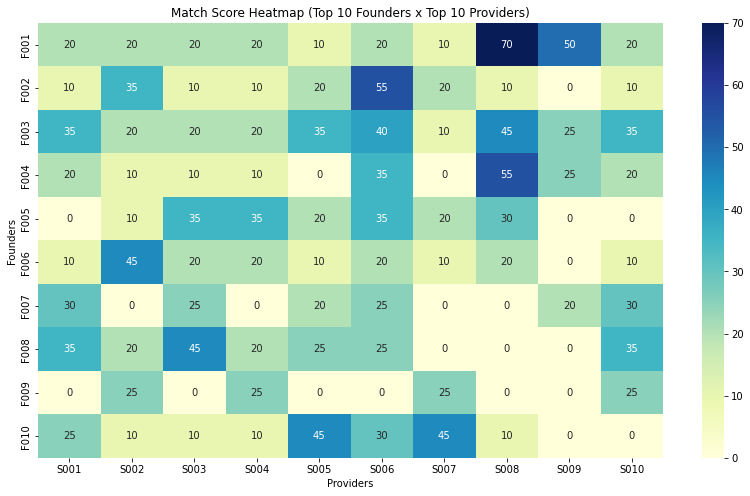

In [10]:
plt.figure(figsize=(14, 8))
sample_matrix = match_matrix.iloc[:10, :10]  # sample for readability
sns.heatmap(sample_matrix, annot=True, cmap="YlGnBu", fmt=".0f")
plt.title("Match Score Heatmap (Top 10 Founders x Top 10 Providers)")
plt.xlabel("Providers")
plt.ylabel("Founders")
plt.show()


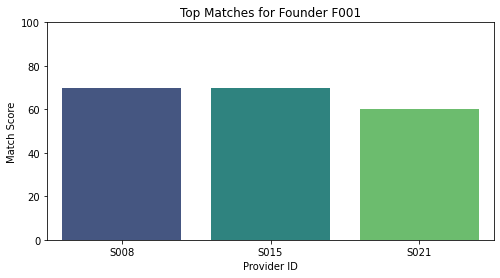

In [11]:
sample_founder = founder_summary_df[founder_summary_df['user_id'] == 'F001']
plt.figure(figsize=(8, 4))
sns.barplot(data=sample_founder, x='match_id', y='match_score', palette='viridis')
plt.title("Top Matches for Founder F001")
plt.xlabel("Provider ID")
plt.ylabel("Match Score")
plt.ylim(0, 100)
plt.show()


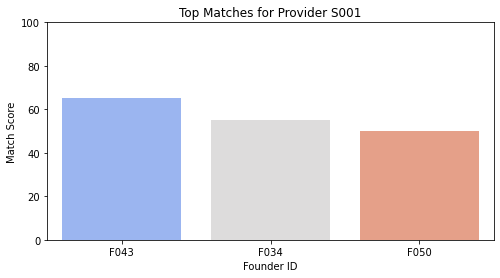

In [12]:
sample_provider = [row for row in provider_summary if row['provider_id'] == 'S001']
sample_provider_df = pd.DataFrame(sample_provider)
plt.figure(figsize=(8, 4))
sns.barplot(data=sample_provider_df, x='founder_id', y='match_score', palette='coolwarm')
plt.title("Top Matches for Provider S001")
plt.xlabel("Founder ID")
plt.ylabel("Match Score")
plt.ylim(0, 100)
plt.show()
